In [1]:
!git clone https://github.com/ayyucedemirbas/COVID-19_CT_Scan_Classification.git

Cloning into 'COVID-19_CT_Scan_Classification'...
remote: Enumerating objects: 2645, done.
remote: Counting objects: 100% (157/157), done.
remote: Compressing objects: 100% (111/111), done.
remote: Total 2645 (delta 61), reused 120 (delta 40), pack-reused 2488
Receiving objects: 100% (2645/2645), 251.69 MiB | 26.09 MiB/s, done.
Resolving deltas: 100% (62/62), done.
Updating files: 100% (2488/2488), done.


In [2]:
!mv COVID-19_CT_Scan_Classification/dataset .

In [3]:
!rm -rf COVID-19_CT_Scan_Classification

In [1]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from PIL import Image
import torchvision
import torch.nn as nn
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import torch
import os
import time
import random
from tqdm import tqdm
%matplotlib inline

In [2]:
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
from torchvision import datasets, transforms, models

In [3]:
from torchvision import transforms as transforms

In [4]:
import torch.optim as optim

In [5]:
import torch.nn.functional as F

In [6]:
from torch.utils.data.sampler import SubsetRandomSampler

In [10]:
!ls -al dataset/train

total 80
drwxr-xr-x 4 root root  4096 Feb 20 15:34 ./
drwxr-xr-x 4 root root  4096 Feb 20 15:34 ../
drwxr-xr-x 2 root root 36864 Feb 20 15:34 COVID/
drwxr-xr-x 2 root root 36864 Feb 20 15:34 non-COVID/


In [7]:
dirCOVID = 'dataset/train/COVID'
dirNonCOVID = 'dataset/train/non-COVID'
data_dir = 'dataset/train'

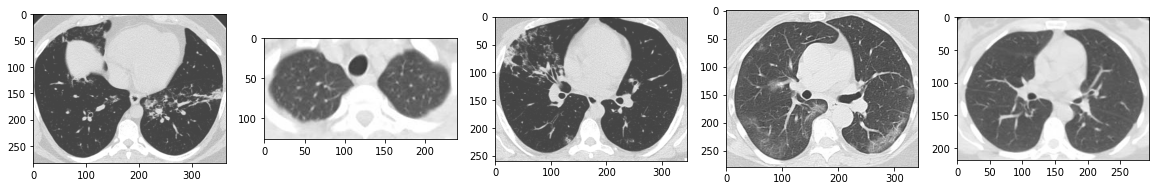

In [12]:
covid_files      = [os.path.join(dirCOVID , x) for x in os.listdir(dirCOVID)]
covid_images    =  [cv2.imread(x) for x in random.sample(covid_files, 5)]

plt.figure(figsize=(20,10))
columns = 5
for i, image in enumerate(covid_images):
    plt.subplot(len(covid_images) / columns + 1, columns, i + 1)
    plt.imshow(image)

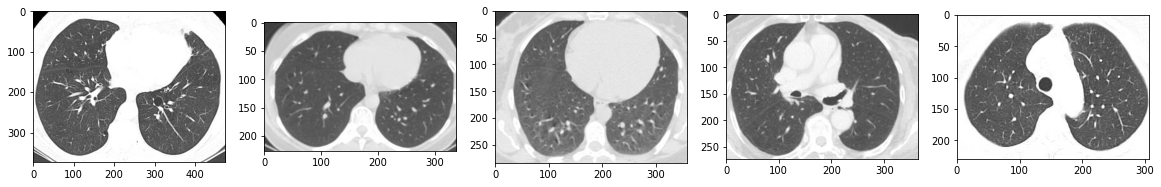

In [13]:
covid_files      = [os.path.join(dirNonCOVID , x) for x in os.listdir(dirNonCOVID)]
covid_images    =  [cv2.imread(x) for x in random.sample(covid_files, 5)]

plt.figure(figsize=(20,10))
columns = 5
for i, image in enumerate(covid_images):
    plt.subplot(len(covid_images) / columns + 1, columns, i + 1)
    plt.imshow(image)

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
print(device)

cuda


In [10]:
def load_split_train_test(datadir, valid_size = .2):
    train_transforms = transforms.Compose([transforms.Resize((300,300)),
                                       transforms.ToTensor(),
                                       ])
    test_transforms = transforms.Compose([transforms.Resize((300, 300)),
                                      transforms.ToTensor(),
                                      ])
    train_data = datasets.ImageFolder(datadir,       
                    transform=train_transforms)
    test_data = datasets.ImageFolder(datadir,
                    transform=test_transforms)
    num_train = len(train_data)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    np.random.shuffle(indices)
    
    train_idx, test_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)
    trainloader = torch.utils.data.DataLoader(train_data,
                   sampler=train_sampler, batch_size=64)
    testloader = torch.utils.data.DataLoader(test_data,
                   sampler=test_sampler, batch_size=64)
    return trainloader, testloader
trainloader, testloader = load_split_train_test(data_dir, .2)
print(trainloader.dataset.classes)

['COVID', 'non-COVID']


In [11]:
model = models.resnet50(pretrained=True)
print(model)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [12]:
model.fc = nn.Sequential(nn.Linear(2048, 512), #overwrite on the model's fully connected(fc) layer
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(512, 2),
                                 nn.LogSoftmax(dim=1))
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.003)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
"""class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 3 input image channel, 16 output channels, 3x3 square convolution kernel
        self.conv1 = nn.Conv2d(3,16,kernel_size=3,stride=2,padding=1)
        self.conv2 = nn.Conv2d(16, 32,kernel_size=3,stride=2, padding=1)
        self.conv3 = nn.Conv2d(32, 64,kernel_size=3,stride=2, padding=1)
        self.conv4 = nn.Conv2d(64, 64,kernel_size=3,stride=2, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout2d(0.4)
        self.batchnorm1 = nn.BatchNorm2d(16)
        self.batchnorm2 = nn.BatchNorm2d(32)
        self.batchnorm3 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64*5*5,512 )
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 2)
        
    def forward(self, x):
        x = self.batchnorm1(F.relu(self.conv1(x)))
        x = self.batchnorm2(F.relu(self.conv2(x)))
        x = self.dropout(self.batchnorm2(self.pool(x)))
        x = self.batchnorm3(self.pool(F.relu(self.conv3(x))))
        x = self.dropout(self.conv4(x))
        x = x.view(-1, 64*5*5) # Flatten layer
        x = self.dropout(self.fc1(x))
        x = self.dropout(self.fc2(x))
        x = F.log_softmax(self.fc3(x),dim = 1)
        return x"""

In [ ]:
"""model = Net()"""


'model = Net()'

In [13]:
# defining the optimizer
optimizer = Adam(model.parameters(), lr=0.07)
# defining the loss function
criterion = CrossEntropyLoss()
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
    

In [14]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [15]:
epochs = 20
steps = 0
running_loss = 0
print_every = 10
train_losses, test_losses = [], []
for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device),labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    test_loss += batch_loss.item()
                    
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals =  top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            train_losses.append(running_loss/len(trainloader))
            test_losses.append(test_loss/len(testloader))                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            running_loss = 0
            model.train()
torch.save(model, 'covidlmodel.pth')


Epoch 1/20.. Train loss: 89.710.. Test loss: 337191702564587840.000.. Test accuracy: 0.518
Epoch 1/20.. Train loss: 2.379.. Test loss: 18544656159305.145.. Test accuracy: 0.470
Epoch 2/20.. Train loss: 6.554.. Test loss: 276534976.000.. Test accuracy: 0.470
Epoch 2/20.. Train loss: 0.640.. Test loss: 1593848.768.. Test accuracy: 0.458
Epoch 2/20.. Train loss: 0.637.. Test loss: 107178.719.. Test accuracy: 0.461
Epoch 3/20.. Train loss: 0.681.. Test loss: 3481.215.. Test accuracy: 0.562
Epoch 3/20.. Train loss: 0.782.. Test loss: 143.908.. Test accuracy: 0.561
Epoch 4/20.. Train loss: 0.816.. Test loss: 446.179.. Test accuracy: 0.586
Epoch 4/20.. Train loss: 0.754.. Test loss: 53.793.. Test accuracy: 0.559
Epoch 4/20.. Train loss: 0.707.. Test loss: 41.903.. Test accuracy: 0.539
Epoch 5/20.. Train loss: 0.668.. Test loss: 25.901.. Test accuracy: 0.562
Epoch 5/20.. Train loss: 0.662.. Test loss: 0.721.. Test accuracy: 0.554
Epoch 6/20.. Train loss: 0.677.. Test loss: 19.072.. Test accura

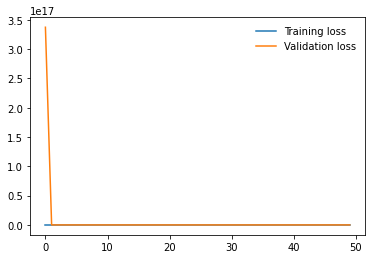

In [16]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()